# Kaggle Challenge Report - IMA205 

---

#### Author : Alexandre HEYMANN

In [14]:
from PIL import Image
from imblearn.over_sampling import RandomOverSampler
from keras.layers import Input, Concatenate, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from skimage.io import imread
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import models, transforms
from torchvision import transforms
from skimage.measure import regionprops, label
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
from tqdm import tqdm
import cv2
import largestinteriorrectangle
import numpy as np
import os
import pandas as pd
import seaborn
import tensorflow as tf
import torch
import torch.nn as nn

---

This project/challenge is a skin lesion classification problem. The goal is to predict a class among 8, given an image of a lesion. To do so, we'll use two different Machine Learning methods : 
- Random Forst Classifier 

- Neural Network 

We'll see that the one that gives best result is the Neural Network, but both are interesting to use and leads to different problems.

---

# <span style="color:red">1. Random Forest Classifier</span>


# Preprocess the data

Preprocess the data is an important and the first step for ML task as it able to have more exploitable and lisible data.

### a) Resize

First we need to resize the image. We will use the 256x256 size since it is a common size for ML task.

PS : I later realized that images of size 224x224 were better to use (as we will see in the case of the neural network).

In [15]:
def resize(img):
    return cv2.resize(img, (256, 256))

### b) Smoothing using median filter

Dermoscopy images often contain superfluous artifacts such as skin lines or air bubbles around the lesion. These elements reduce the accuracy of contour detection and increase processing time. To mitigate the adverse effects of these artifacts, images should be preprocessed with a smoothing filter.

The median filter is one of the most common smoothing filters. Median filtering with an appropriate mask size can eliminate most artifacts in a dermoscopy image. According to numerous research articles, the mask size should be proportional to the image size for optimal results, and the mathematical relationship is as follows: given an image of size M by N, the mask size n is determined by:

$$ n = \left\lfloor 5\sqrt{\frac{M}{768}\frac{N}{512}} \right\rfloor $$

With M=N=224, we obtain n=1

In [16]:
def median_filter(img, kernel_size):
    return cv2.medianBlur(img, kernel_size)

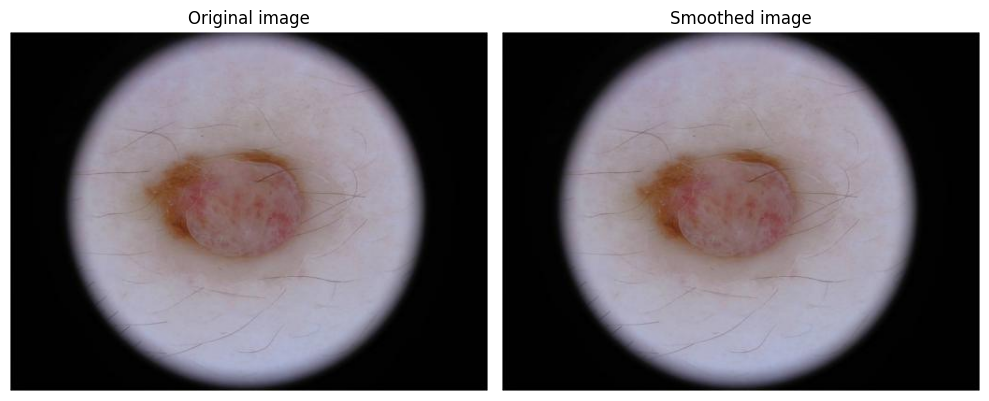

In [5]:
''' Exemple of usage '''

image_path = 'Test/Test/ISIC_0000071.jpg'
image = cv2.imread(image_path)

image_lisse = median_filter(image, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_lisse, cv2.COLOR_BGR2RGB))
plt.title('Smoothed image')
plt.axis('off')

plt.tight_layout()
plt.show()

### c) Remove hairs 

Some image have hairs that may perturbs the analysis. We have to remove them. Here we are using Dull Razor algorithm to do so.

In [19]:
def remove_hair(image):
    # DULL RAZOR (REMOVE HAIR)

    # Gray scale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Black hat filter
    kernel = cv2.getStructuringElement(1, (9, 9))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    # Gaussian filter
    bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
    # Binary thresholding (MASK)
    ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    # Replace pixels of the mask
    dst = cv2.inpaint(image, mask, 6, cv2.INPAINT_TELEA)

    return dst

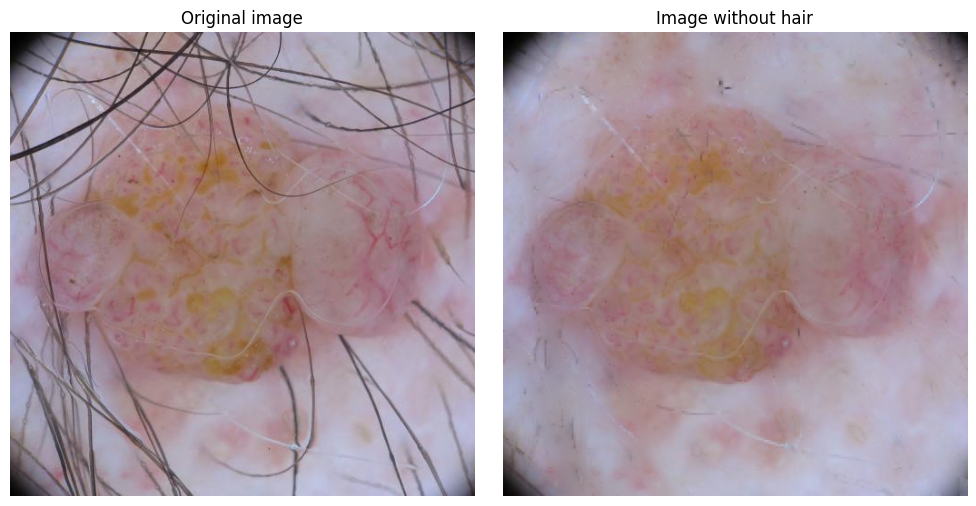

In [7]:
'''Exemple of usage'''

image_path = 'Test/Test/ISIC_0057760.jpg'
image_original = cv2.imread(image_path)

image_resize = resize(image_original)
image_lisse = median_filter(image_resize, 1)
image_sans_poils = remove_hair(image_lisse)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB))
plt.title('Original image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_sans_poils, cv2.COLOR_BGR2RGB))
plt.title('Image without hair')
plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
def remove_hair(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, thresh2 = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    inpainted = cv2.inpaint(image, thresh2, 1, cv2.INPAINT_TELEA)
    return inpainted

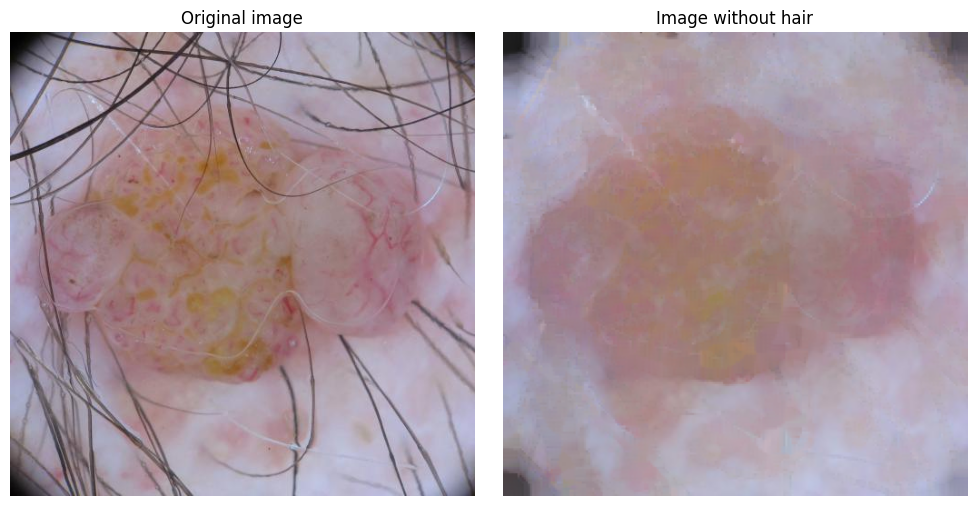

In [9]:
'''Exemple of usage'''

image_path = 'Test/Test/ISIC_0057760.jpg'
image_original = cv2.imread(image_path)

image_resize = resize(image_original)
image_lisse = median_filter(image_resize, 1)
image_sans_poils = remove_hair(image_lisse)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB))
plt.title('Original image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_sans_poils, cv2.COLOR_BGR2RGB))
plt.title('Image without hair')
plt.axis('off')

plt.tight_layout()
plt.show()

### d) Combine all functions

In [20]:
def pre_process(img):
    image = resize(img)
    image = median_filter(image, 1)
    # If the image is in grayscale
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = remove_hair(image)
    # Convert the image to a numpy array
    image = np.array(image)
    # Normalize the image
    image = image / 255.0
    return image

In [12]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)  # Convertir PIL Image en ndarray
    image = remove_hair(image)  # Appel de la fonction remove_hair
    image = Image.fromarray(image)  # Convertir ndarray en PIL Image

    # Transformation pour la normalisation et le redimensionnement
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = transform(image)
    return image

---

# Segmentation

We are using U-Net for segmentation because it is widely use in medical image analysis. Indeed, it has an ability to capture high-resolution features and context information. The U-Net architecture consists of a contracting path (encoder) and an expanding path (decoder). The contracting path is used to capture context information, while the expanding path is used to localize the object of interest at high resolution. The encoder and decoder are connected by skip connections, which allow the network to propagate low-level features from the encoder to the decoder. 

In [ ]:
# Load the data into an array list
def load_data(folder):
    images = []
    masks = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(folder, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = pre_process(img)
            images.append(img)
        elif filename.endswith('_seg.png'):
            mask = cv2.imread(os.path.join(folder, filename),
                              cv2.IMREAD_GRAYSCALE)
            mask = resize(mask)
            mask = np.array(mask)
            mask = mask / 255.0
            masks.append(mask)
    images = np.array(images)
    masks = np.array(masks)
    return images, masks

images, masks = load_data("Segmentation")


# U-Net for segmentation
def unet_model(input_size=(224, 224, 3)):
    inputs = tf.keras.Input(shape=input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(images, masks, batch_size=128, epochs=10, validation_split=0.2)

model.save_weights('model.weights.h5')
model.save('model.h5')

KeyboardInterrupt: 

In [22]:
# Charger le modèle entraîné
model = load_model('model/model.keras')


def predict_mask(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = pre_process(image)

    image = np.expand_dims(image, axis=0)

    # Prediction using U-Net model
    mask = model.predict(image)
    plt.imshow(mask[0, :, :, 0], cmap='gray')

    mask = np.squeeze(mask) * 255
    mask = mask.astype(np.uint8)

    # Apply Otsu's thresholding to get a binary mask
    _, binary_mask = cv2.threshold(
        mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_mask


'''Finally, as the mask is a binary image, we can apply it to the original image to segment the mole.'''
'''The following function takes an image path as input and returns the segmented image:'''


def segmented_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image '{image_path}'")
        return None

    # Convert to RGB color space and preprocess
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = pre_process(image)

    # Ensure the image is scaled back up to 0-255 and converted to uint8
    image = (image * 255).astype(np.uint8)

    # Predict the mask
    mask = predict_mask(image_path)
    if mask is None:
        print(f"Error: Unable to predict mask for image '{image_path}'")
        return None

    # Resize mask to match image dimensions
    mask = cv2.resize(
        mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Apply the mask directly to the original image
    segmented_image = cv2.bitwise_and(image, image, mask=mask)
    return segmented_image

In [23]:
def segment_all_images(folder):
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            segmented_img = segmented_image(os.path.join(folder, filename))
            if segmented_img is not None:
                cv2.imwrite(f'Segmented_images/test/{filename}',
                            cv2.cvtColor(segmented_img, cv2.COLOR_RGB2BGR))
                print(len(os.listdir('Segmented_images/test')))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
24
1

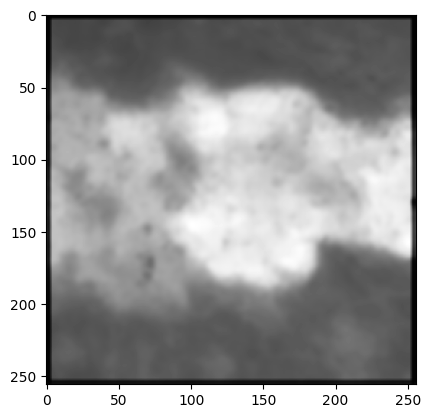

In [24]:
segment_all_images('Test/Test')

(-0.5, 255.5, 255.5, -0.5)

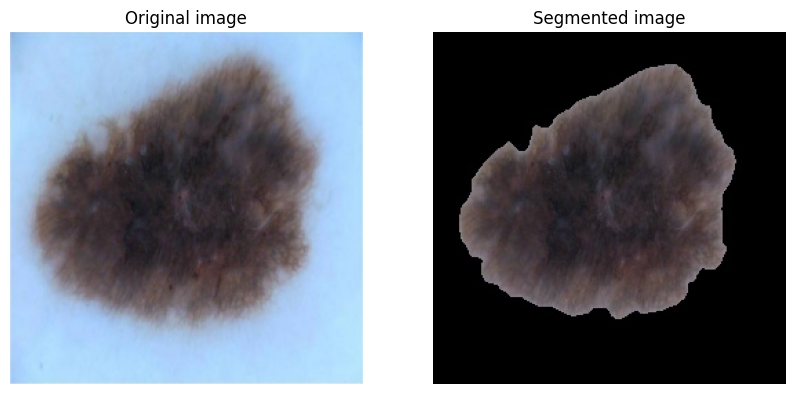

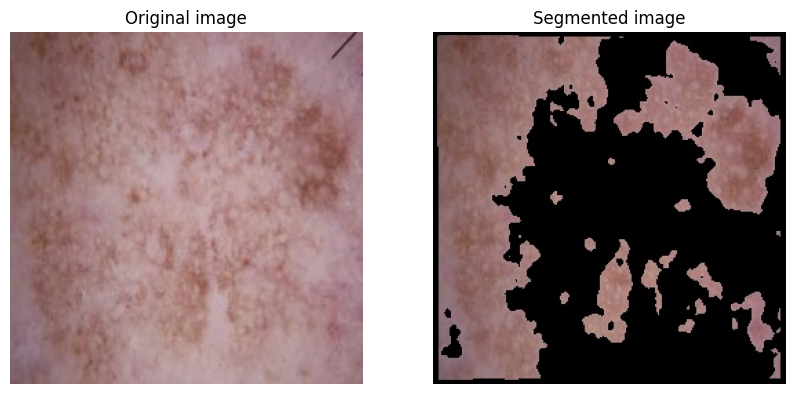

In [25]:
# Display the original and segmented images side by side for a good segmentation
original_img = cv2.imread('Train/Train/ISIC_0000000.jpg')
original_img = cv2.resize(original_img, (256, 256))
segmented_img = cv2.imread('Segmented_img/train/ISIC_0000000.jpg')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title('Original image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
plt.title('Segmented image')
plt.axis('off')
# Display the original and segmented images side by side for a bad segmentation
original_img = cv2.imread('Train/Train/ISIC_0026378.jpg')
original_img = cv2.resize(original_img, (256, 256))
segmented_img = cv2.imread('Segmented_img/train/ISIC_0026378.jpg')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title('Original image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
plt.title('Segmented image')
plt.axis('off')

# Post processing

As a post-processing operation, we are using edge refinement to try to get rid of some edges that may disturb the algorithm. However, after many attempts, we lose too much contrast and textures to gain just a little refinement. So I choose not to keep it.

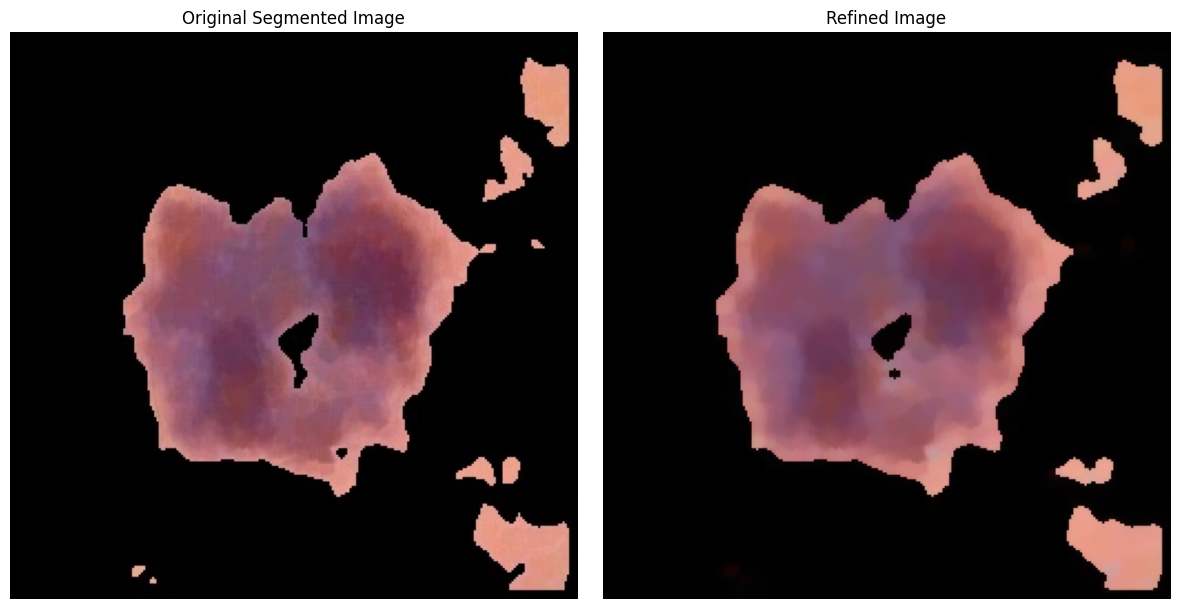

In [43]:
def refine_edges(image_path, kernel_size=5):
    """
    Apply morphological operations and edge refinement to clean up segmentation results and remove edge artifacts.

    Parameters:
        image_path (str): Path to the segmented image file.
        kernel_size (int): Size of the structuring element for initial morphological operations.

    Returns:
        np.array: Processed image array with edges refined.
    """
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Create structuring element for morphological operations
    kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    # Split the image into separate color channels
    b, g, r = cv2.split(image)

    # Apply morphological closing to close small holes and opening to remove noise on each channel
    b = cv2.morphologyEx(b, cv2.MORPH_CLOSE, kernel)
    b = cv2.morphologyEx(b, cv2.MORPH_OPEN, kernel)
    g = cv2.morphologyEx(g, cv2.MORPH_CLOSE, kernel)
    g = cv2.morphologyEx(g, cv2.MORPH_OPEN, kernel)
    r = cv2.morphologyEx(r, cv2.MORPH_CLOSE, kernel)
    r = cv2.morphologyEx(r, cv2.MORPH_OPEN, kernel)

    # Further refine the edges by eroding and then dilating the image on each channel
    b = cv2.erode(b, kernel, iterations=1)
    b = cv2.dilate(b, kernel, iterations=1)
    g = cv2.erode(g, kernel, iterations=1)
    g = cv2.dilate(g, kernel, iterations=1)
    r = cv2.erode(r, kernel, iterations=1)
    r = cv2.dilate(r, kernel, iterations=1)

    # Merge the color channels back into a single image
    image = cv2.merge([b, g, r])

    return image


# Path to the segmented image with edge issues
edge_problem_image_path = 'Segmented_images/test/ISIC_0000193.jpg'
edge_image = cv2.imread(edge_problem_image_path, cv2.IMREAD_COLOR)

# Apply the edge refinement function
refined_image = refine_edges(edge_problem_image_path)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(edge_image, cv2.COLOR_BGR2RGB))
plt.title('Original Segmented Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(refined_image, cv2.COLOR_BGR2RGB))
plt.title('Refined Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Analysis of the csv file

Now that we have pre-preprocessed our data we need to analyse the given csv file to check the distribution of the class, the proportion of male/female, and many other usefull informations.

In [12]:
# First we load our data
df = pd.read_csv('csv_files/metadataTrain.csv')

print(df.head())

             ID  CLASS     SEX   AGE         POSITION
0  ISIC_0028766      2    male  30.0              NaN
1  ISIC_0071222      8    male  85.0  lower extremity
2  ISIC_0069434      3    male  85.0        head/neck
3  ISIC_0062098      1    male  55.0        head/neck
4  ISIC_0057224      8  female  45.0  lower extremity


Column sex and position are not numerical values. We're gonna fix this issue later on.

In [13]:
unique_sexes = df['SEX'].unique()
print("Unique value in the column 'SEX' :")
print(unique_sexes)

unique_positions = df['POSITION'].unique()
print("\nUnique value in the column 'POSITION' :")
print(unique_positions)

Unique value in the column 'SEX' :
['male' 'female' nan]

Unique value in the column 'POSITION' :
[nan 'lower extremity' 'head/neck' 'anterior torso' 'posterior torso'
 'upper extremity' 'palms/soles' 'oral/genital' 'lateral torso']


As we can see the value 'NaN' appear which means that there is missing data. We need more informations about those.

In [14]:
missing_values = df.isna()
print(missing_values.sum())

ID             0
CLASS          0
SEX          284
AGE          324
POSITION    1970
dtype: int64


Before fixing missing data issue we need to convert to numerical values to be treated by the machine. To do that we're creating a dictionnary.

In [15]:
sex_map = {'female': 0, 'male': 1}
df['SEX'] = df['SEX'].map(sex_map)

In [16]:
print(df.head())

             ID  CLASS  SEX   AGE         POSITION
0  ISIC_0028766      2  1.0  30.0              NaN
1  ISIC_0071222      8  1.0  85.0  lower extremity
2  ISIC_0069434      3  1.0  85.0        head/neck
3  ISIC_0062098      1  1.0  55.0        head/neck
4  ISIC_0057224      8  0.0  45.0  lower extremity


In [17]:
position_map = {
    'lower extremity': 0,
    'head/neck': 1,
    'anterior torso': 2,
    'posterior torso': 3,
    'upper extremity': 4,
    'palms/soles': 5,
    'oral/genital': 6,
    'lateral torso': 7
}

# Replace NaN by -1 (convention)
df['POSITION'].fillna('missing', inplace=True)
position_map['missing'] = -1

df['POSITION'] = df['POSITION'].map(position_map)

print(df.head())

             ID  CLASS  SEX   AGE  POSITION
0  ISIC_0028766      2  1.0  30.0        -1
1  ISIC_0071222      8  1.0  85.0         0
2  ISIC_0069434      3  1.0  85.0         1
3  ISIC_0062098      1  1.0  55.0         1
4  ISIC_0057224      8  0.0  45.0         0


Now let's take a look at the distribution

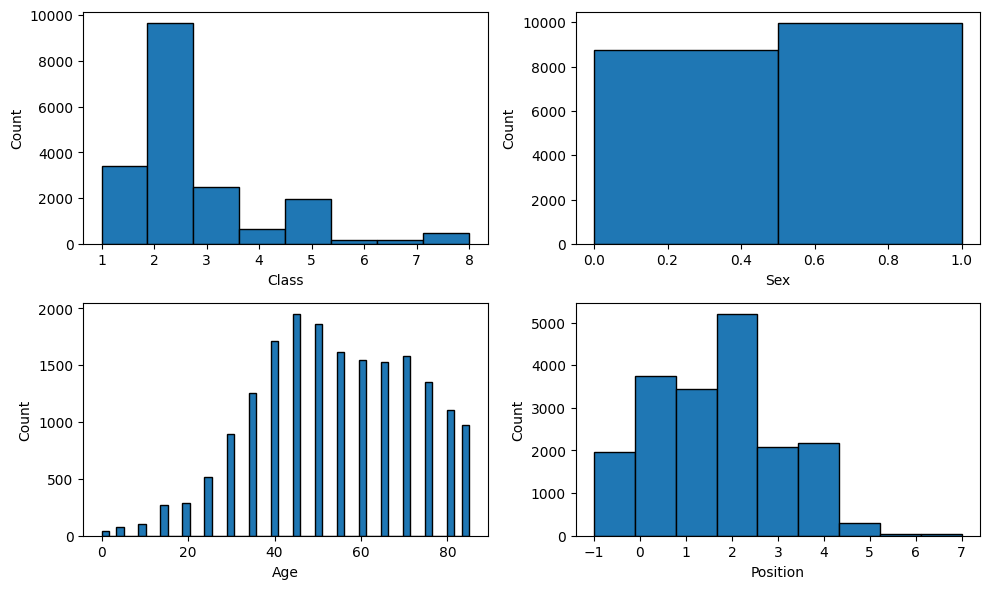

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# CLASS histogram
axs[0, 0].hist(df['CLASS'], bins=8, edgecolor='black')
axs[0, 0].set_xlabel('Class')
axs[0, 0].set_ylabel('Count')

# SEX histogram
axs[0, 1].hist(df['SEX'], bins=2, edgecolor='black')
axs[0, 1].set_xlabel('Sex')
axs[0, 1].set_ylabel('Count')

# AGE histogram
axs[1, 0].hist(df['AGE'], bins=50, edgecolor='black')
axs[1, 0].set_xlabel('Age')
axs[1, 0].set_ylabel('Count')

# POSITION histogram
axs[1, 1].hist(df['POSITION'], bins=9, edgecolor='black')
axs[1, 1].set_xlabel('Position')
axs[1, 1].set_ylabel('Count')


plt.tight_layout()
plt.show()

Now we want to fix the missing data problem. To do so, we're looking if it exist a correlation between the features.

In [19]:
df_corr = df.drop('ID', axis=1)

# Correlation matrix
corr_matrix = df_corr.corr()
print(corr_matrix)

             CLASS       SEX       AGE  POSITION
CLASS     1.000000  0.045972  0.240100 -0.062688
SEX       0.045972  1.000000  0.149605  0.050615
AGE       0.240100  0.149605  1.000000  0.036171
POSITION -0.062688  0.050615  0.036171  1.000000


There is not really a correlation between the features so as there is more man than women, we're gonna replace missing data by women.

In [20]:
df['SEX'] = df['SEX'].fillna(0)

For the age, the correlation between age and class is the higher (0.25) so we're creating a regression to predict missing data.

In [21]:
df_notnull = df[df['AGE'].notnull()]
df_null = df[df['AGE'].isnull()]

# Linear regression model
X = df_notnull[['CLASS']]
y = df_notnull['AGE']
reg = LinearRegression().fit(X, y)

df_null['AGE'] = reg.predict(df_null[['CLASS']])

df['AGE'] = df['AGE'].fillna(df_null['AGE'])
df['AGE'] = np.round(df['AGE'] / 5) * 5

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_107344\3264094967.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null['AGE'] = reg.predict(df_null[['CLASS']])


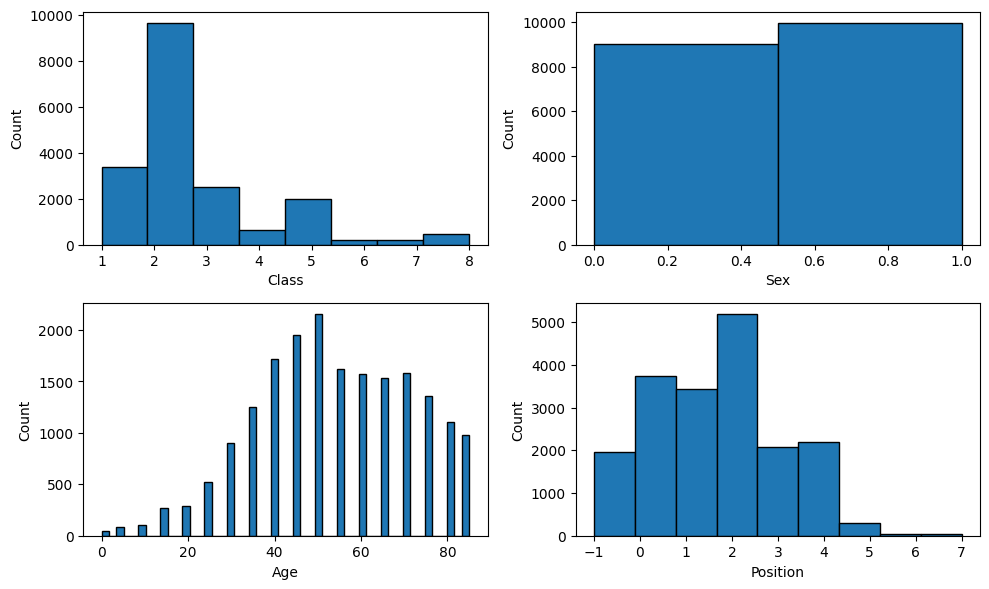

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# CLASS histogram
axs[0, 0].hist(df['CLASS'], bins=8, edgecolor='black')
axs[0, 0].set_xlabel('Class')
axs[0, 0].set_ylabel('Count')

# SEX histogram
axs[0, 1].hist(df['SEX'], bins=2, edgecolor='black')
axs[0, 1].set_xlabel('Sex')
axs[0, 1].set_ylabel('Count')

# AGE histogram
axs[1, 0].hist(df['AGE'], bins=50, edgecolor='black')
axs[1, 0].set_xlabel('Age')
axs[1, 0].set_ylabel('Count')

# POSITION histogram
axs[1, 1].hist(df['POSITION'], bins=9, edgecolor='black')
axs[1, 1].set_xlabel('Position')
axs[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Finally for the position as there is no link between features, we're gonna add randomly a value

In [23]:
random_positions = np.random.choice(range(5), size=df['POSITION'].eq(-1).sum())
df.loc[df['POSITION'] == -1, 'POSITION'] = random_positions

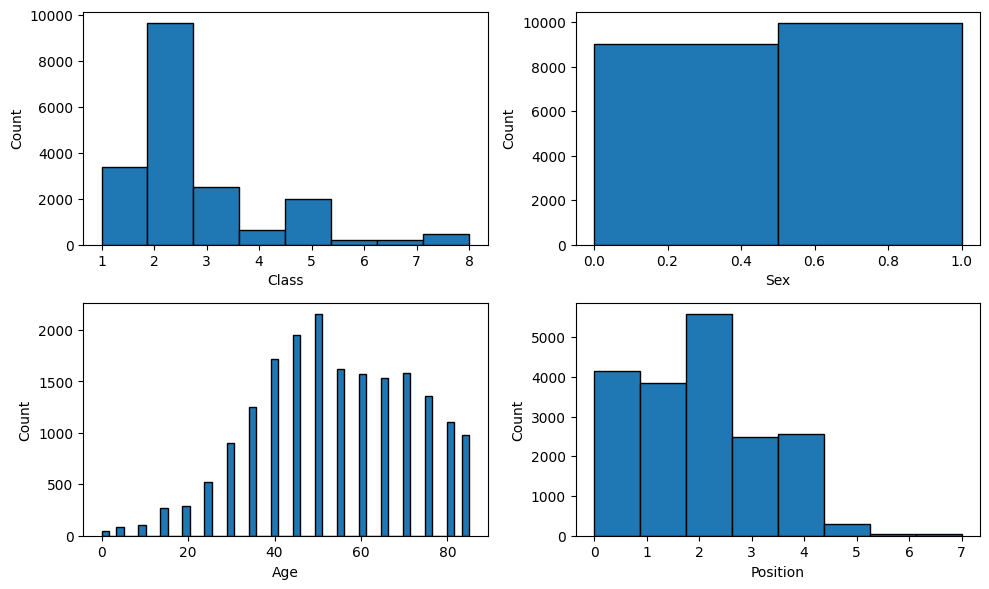

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# CLASS histogram
axs[0, 0].hist(df['CLASS'], bins=8, edgecolor='black')
axs[0, 0].set_xlabel('Class')
axs[0, 0].set_ylabel('Count')

# SEX histogram
axs[0, 1].hist(df['SEX'], bins=2, edgecolor='black')
axs[0, 1].set_xlabel('Sex')
axs[0, 1].set_ylabel('Count')

# AGE histogram
axs[1, 0].hist(df['AGE'], bins=50, edgecolor='black')
axs[1, 0].set_xlabel('Age')
axs[1, 0].set_ylabel('Count')

# POSITION histogram
axs[1, 1].hist(df['POSITION'], bins=8, edgecolor='black')
axs[1, 1].set_xlabel('Position')
axs[1, 1].set_ylabel('Count')


plt.tight_layout()
plt.show()

In [25]:
missing_values = df.isna()
print(missing_values.sum())

ID          0
CLASS       0
SEX         0
AGE         0
POSITION    0
dtype: int64


# Extract Features

The given csv file gives us informations about the sex, position and age. Those are important data but are not enough to determine the class of a new image. We thus need more features to extract.

In [3]:
def calculate_asymmetry(image):
    h, w = image.shape
    vertical_asymmetry = np.sum(
        np.abs(image[:, :w//2] - np.fliplr(image[:, w//2:])))
    horizontal_asymmetry = np.sum(
        np.abs(image[:h//2, :] - np.flipud(image[h//2:, :])))
    total_asymmetry = int(
        (vertical_asymmetry + horizontal_asymmetry) / (h * w))
    return total_asymmetry


def calculate_border_irregularity(image):
    contours, _ = cv2.findContours(
        image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)
    compactness = int((perimeter**2) / area) if area != 0 else 0
    return compactness


def calculate_color_variability(image, n_clusters=3):
    pixels = image.reshape((-1, 3))
    pixels = pixels[np.any(pixels != [0, 0, 0], axis=1)
                    ]  # Exclude black background
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pixels)
    return len(np.unique(kmeans.labels_))


def calculate_diameter(image):
    contours, _ = cv2.findContours(
        image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    if len(contour) < 3:
        return 0  # Not enough points to form a shape
    hull = ConvexHull(contour.reshape(-1, 2))
    diameter = max([np.linalg.norm(contour[hull.vertices[i]] - contour[hull.vertices[j]])
                    for i in range(len(hull.vertices))
                    for j in range(i + 1, len(hull.vertices))])
    return int(diameter)

c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


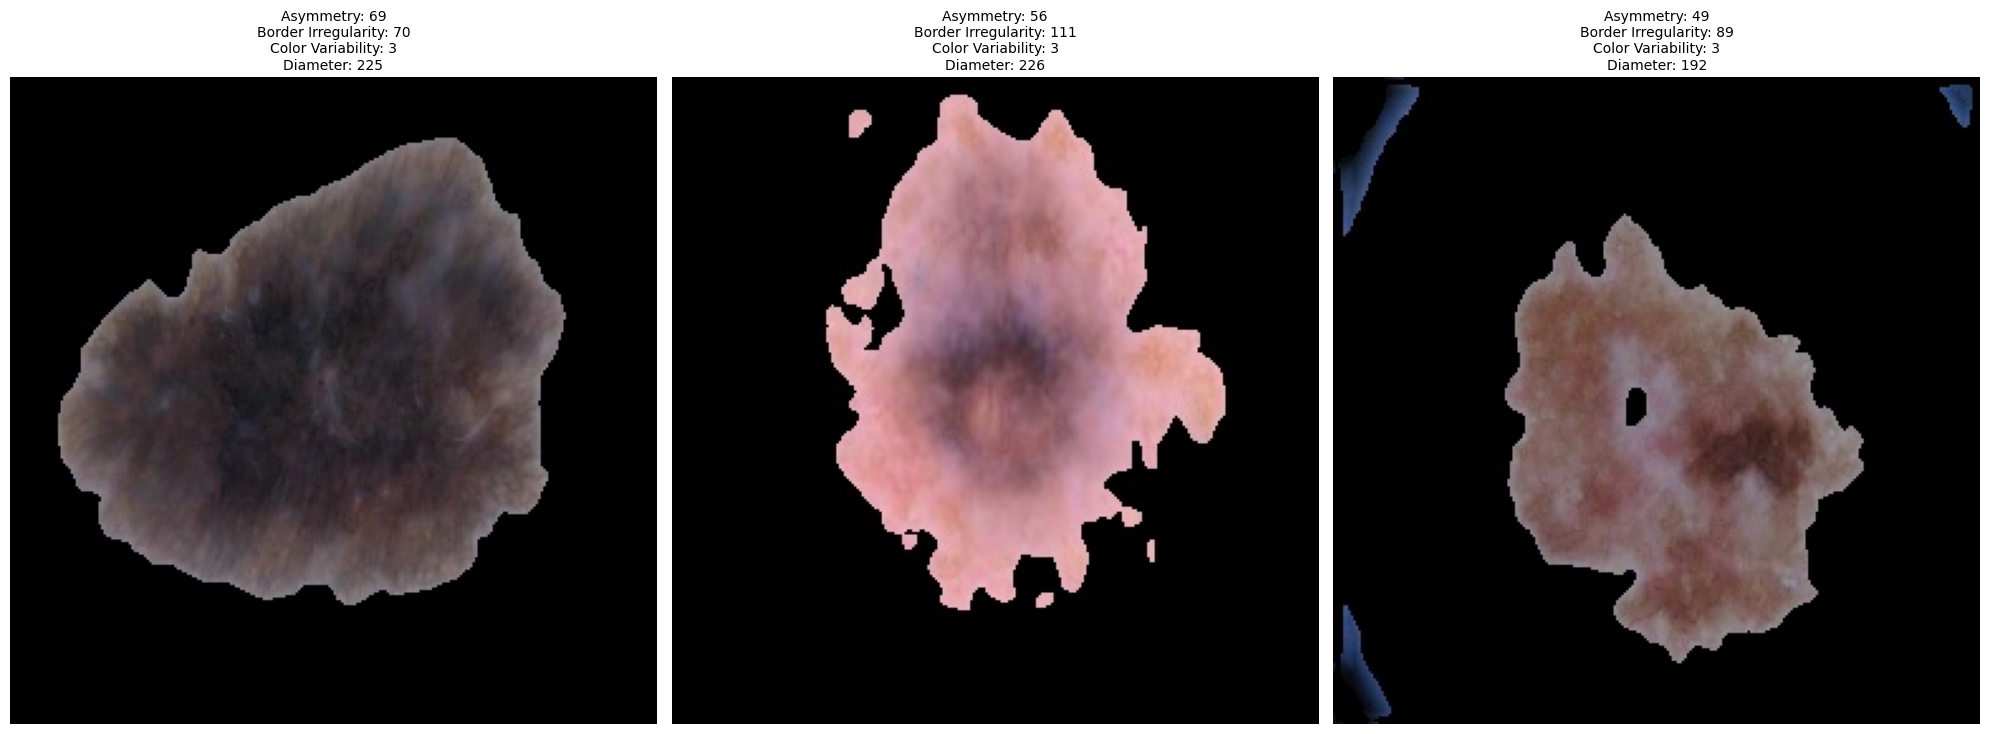

In [7]:
# List of image paths
image_paths = ['Segmented_img/train/ISIC_0000000.jpg', 'Segmented_img/train/ISIC_0024721.jpg',
               'Segmented_img/train/ISIC_0000002.jpg']  # replace with actual paths

# create a figure with a single row and multiple columns
fig, axs = plt.subplots(1, len(image_paths), figsize=(20, 10))

for i, ip in enumerate(image_paths):
    # Load image
    image = cv2.imread(ip)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute features
    asymmetry = calculate_asymmetry(gray_image)
    border_irregularity = calculate_border_irregularity(gray_image)
    color_variability = calculate_color_variability(
        image)  # Use original color image
    diameter = calculate_diameter(gray_image)

    # Display image and its features
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[i].set_title(
        f"Asymmetry: {asymmetry}\nBorder Irregularity: {border_irregularity}\nColor Variability: {color_variability}\nDiameter: {diameter}", fontsize=10)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

Results seems pretty reliable. We now want to complete our csv file to add those features.

In [10]:
df = pd.read_csv('csv_files/metadataTest.csv')

# Create new columns for the features
if 'A' not in df.columns:
    df['A'] = None
if 'B' not in df.columns:
    df['B'] = None
if 'C' not in df.columns:
    df['C'] = None
if 'D' not in df.columns:
    df['D'] = None

image_dir = 'Segmented_img/test/'

for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    image_id = row['ID']

    image_path = os.path.join(image_dir, f'{image_id}.jpg')

    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    a = calculate_asymmetry(gray_image)
    b = calculate_border_irregularity(gray_image)
    c = calculate_color_variability(image)
    d = calculate_diameter(gray_image)

    df.loc[i, 'A'] = a
    df.loc[i, 'B'] = b
    df.loc[i, 'C'] = c
    df.loc[i, 'D'] = d

df.to_csv('csv_files/metadataTest_2', index=False)

  0%|          | 0/6333 [00:00<?, ?it/s]c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  0%|          | 1/6333 [00:00<15:36,  6.76it/s]c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  0%|          | 2/6333 [00:00<20:44,  5.09it/s]c:\Users\Alexandre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  0%|          | 3/6333 [00:00<18:29,  5.70it/s]c:\Users\

# Predictions using RandomForest Classifier

In [28]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Load training data
train_data = pd.read_csv('csv_files/metadataTrain_2.csv')

# Define features and label columns
feature_columns = ['A', 'B', 'C', 'D']
label_column = 'CLASS'

# Split data into features and labels
X = train_data[feature_columns]
y = train_data[label_column]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)  # 20% validation split

# Initialize the Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
random_forest.fit(X_train, y_train)

# Validate the classifier
y_pred_val = random_forest.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", accuracy_val)
print("Validation Classification Report:\n",
      classification_report(y_val, y_pred_val))

# Load test data
test_data = pd.read_csv('csv_files/metadataTest_2.csv')
X_test = test_data[feature_columns]

# Predict on test data
y_test_pred = random_forest.predict(X_test)

# Optionally, save the predictions to a CSV file
test_data['Predicted_Class'] = y_test_pred
test_data.to_csv('csv_files/predicted_classes.csv', index=False)

Validation Accuracy: 0.4747368421052632
Validation Classification Report:
               precision    recall  f1-score   support

           1       0.28      0.24      0.26       670
           2       0.61      0.76      0.68      1908
           3       0.29      0.25      0.27       513
           4       0.19      0.11      0.14       135
           5       0.16      0.10      0.12       398
           6       0.00      0.00      0.00        37
           7       0.00      0.00      0.00        45
           8       0.09      0.03      0.05        94

    accuracy                           0.47      3800
   macro avg       0.20      0.19      0.19      3800
weighted avg       0.42      0.47      0.44      3800



In [32]:
df_pred = pd.read_csv('new_file.csv')
df_gt = pd.read_csv('csv_files/real_prediction.csv')

df_pred = df_pred.rename(columns={'CLASS': 'CLASS_pred'})
df_gt = df_gt.rename(columns={'CLASS': 'CLASS_gt'})

df_merged = pd.merge(df_pred, df_gt, on='ID')

df_merged['is_different'] = df_merged['CLASS_pred'] != df_merged['CLASS_gt']

count_differences = df_merged['is_different'].sum()

print(f"Number of different classes : {count_differences}")

print(
    f"Proportion of good prediction : {1- count_differences / df_merged.shape[0]}")

Number of different classes : 3368
Proportion of good prediction : 0.46818253592294334


# <span style="color:red">2. Neural Network</span>


# PyTorch

In [ ]:
'''
Function to split indices for train-validation split
'''
def split_indices(n, val_pct):
    # Determine size of validation set
    n_val = int(n * val_pct)
    # Create array of random indices
    idxs = np.random.permutation(n)
    # Return indices for training and validation
    return idxs[n_val:], idxs[:n_val]

'''
Custom Dataset class
'''
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0] + '.jpg')
        image = Image.open(img_name).convert('RGB')  # Ensure image is in RGB mode

        if self.transform:
            image = self.transform(image)

        label = int(self.dataframe.iloc[idx, 1])-1
        return image, label

'''
Custom ResNet model
'''
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.dropout = nn.Dropout(0.5)  # 50% dropout probability
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = self.dropout(x)
        return x

'''
Early Stopping class
'''
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Initialize Early Stopping object
early_stopper = EarlyStopping(patience=5, min_delta=0.01)

# Define transformation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load data
metadataTrain = pd.read_csv('metadataTrain.csv')
train_dataset = CustomDataset(metadataTrain, 'Train/', transform=transform)

# Extract labels for computing class weights
labels = metadataTrain['CLASS'].astype(int).values - 1  # Ensure classes are 0-indexed
classes = np.unique(labels)
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

# Split indices for train-validation split
train_idxs, val_idxs = split_indices(len(train_dataset), 0.2)

# Create DataLoaders for train and validation
train_sampler = SubsetRandomSampler(train_idxs)
val_sampler = SubsetRandomSampler(val_idxs)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=64, sampler=val_sampler)

# Configure device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

# Initialize model
model = CustomResNet(num_classes=8).to(device)

# Change the last layer to match the number of classes
num_ftrs = model.resnet.fc.in_features
model.resnet.fc = nn.Linear(num_ftrs, 8)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

# Convert weights to PyTorch tensor and send to appropriate device
weights_tensor = torch.tensor([class_weights[k] for k in sorted(class_weights.keys())], dtype=torch.float32)
weights_tensor = weights_tensor.to(device)

# Use weights in the loss criterion
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

if device.type == 'cuda':
    print('Using GPU')
else:
    print('Using CPU')

# Training loop
for epoch in range(10):
    model.train()
    epoch_loss = 0
    train_accuracy = 0  
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        train_accuracy += (outputs.argmax(1) == labels).type(torch.float).sum().item()
    train_accuracy /= len(train_idxs)
    epoch_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss, val_accuracy = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            val_accuracy += (outputs.argmax(1) == labels).type(torch.float).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy /= len(val_idxs)
    scheduler.step(val_loss)
    
    if early_stopper(val_loss):
        print("Early stopping")
        break
    
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Train Acc: {train_accuracy}, Val Loss: {val_loss}, Val Acc: {val_accuracy}')


# <span style="color:red">3. Results</span>


We used two main approaches for modeling: Random Forest and a neural network based on ResNet18. Comparing the performances, the neural network achieves a superior precision score of 0.66 against 0.47 for Random Forest. This difference may marks the advantage of deep neural networks in handling complex image processing tasks, where they excel particularly thanks to their ability to capture hierarchical features and adapt to the nuances of image data.